In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1.5)
sns.set_style('white')
colors = sns.color_palette('muted')
nax = np.newaxis

sys.path.append('C:\\Users\\mtr22\\Code\\liGAN')
from results import plot_strips, add_group_column


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We represent molecules in a grid format amenable to convolutional network training. To convert molecules to this format, we assign each atom a type based on a typing scheme that includes the element, aromaticity, hydrophobicity, and H-bond donor/acceptor state. Then, atoms are represented as continuous, Gaussian-like densities on a three-dimensional grid with separate channels for each atom type, analogous to an RGB image. The density of an atom at a grid point is a function of the displacement and the atomic radius:

\begin{align}
    f_t(c) =
    \begin{cases}
    e^{-2(\frac{\|c\|}{r_t})^2} & 0 \leq \|c\| < r_t \\
    \frac{4}{e^2}(\frac{\|c\|}{r_t})^2 - \frac{12}{e^2}\frac{\|c\|}{r_t} + \frac{9}{e^2} & r_t \leq \|c\| < \frac{3}{2}r_t \\
    0 & \frac{3}{2}r_t \leq \|c\| \\
    \end{cases} \\
\end{align}

Given a 3D molecular structure with $N$ atoms and $N_T$ possible atom types as a vector of atom type indices $T \in [1, N_T]^N$ and a matrix of atomic coordinates $C \in \mathbb{R}^{N \times 3}$, the grid values in each atom type channel are computed by summing the density of each atom with the corresponding type at each grid point.

\begin{align*}
    \label{eqn:atom_gridding}
    g(T, C)_{t,x,y,z} = \sum_{i=1}^{N} \mathbf{1}(T_i=t)  f_t(C_i - (x,y,z))
\end{align*}

(31,)


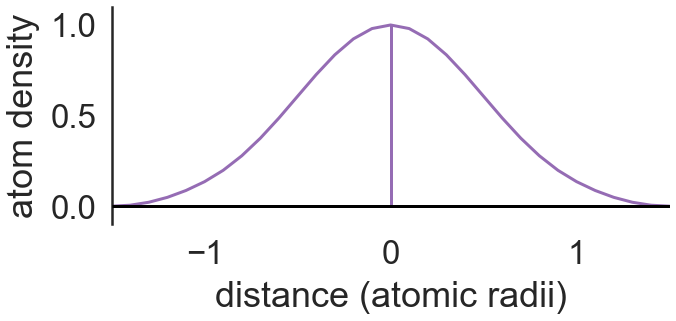

In [55]:
def get_grid_points(center, dimension, resolution):
    n_points = int(np.ceil(dimension/resolution + 1))
    return np.linspace(center - dimension/2, center + dimension/2, n_points)

def get_atom_density(atom_coord, atom_radius, grid_points):
    dist2 = np.sum((atom_coord - grid_points)**2, axis=-1)
    dist = np.sqrt(dist2)
    r, r2 = atom_radius, atom_radius**2
    ie2 = np.exp(-2)
    gauss_val = np.exp(-2*dist2/r2)
    quad_val = 4*ie2*dist2/r2 - 12*ie2*dist/r + 9*ie2
    return np.where(dist < r,     gauss_val, 
           np.where(dist < 1.5*r, quad_val, 0))

resolution = 0.1

atom_radius = 1 # carbon
bond_length = 1.4 # benzene

kernel_dimension = (int(np.ceil(2*1.5*atom_radius/resolution + 1)) - 1)*resolution
kernel_points = get_grid_points(center=0, dimension=kernel_dimension, resolution=resolution)
kernel = get_atom_density(0, atom_radius, kernel_points[:,nax])

print(kernel.shape)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(kernel_points, kernel, color=colors[4])
x_min, x_max = kernel_points.min(), kernel_points.max()
ax.hlines(0, x_min, x_max, zorder=10)
ax.vlines(0, 0, 1, color=colors[4])
ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.1)
#ax.set_xticks(kernel_points)
#ax.set_title('Atom density kernel', fontsize='large')
ax.set_xlabel('distance (atomic radii)', labelpad=10) #r'$\dfrac{\|c\|}{r_t}$')
ax.set_ylabel('atom density', labelpad=10) #'$f_t(c)$')
#ax.grid(True)
sns.despine(fig, top=True, bottom=True, right=True)
fig.savefig('atom_density_kernel.png', bbox_inches='tight', transparent=True)

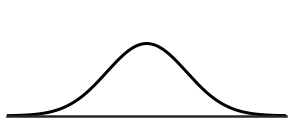

In [45]:
fig, ax = plt.subplots(figsize=(5, 2))
x = np.linspace(-4, 4, 1000)
y = np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
ax.plot(x, y, color='k')
ax.yaxis.set_visible(False)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(0, 0.6)
ax.set_xticks([])
sns.despine(top=True, right=True, left=True)
fig.savefig('normal_distribution.png', bbox_inches='tight', transparent=True, dpi=300)

We formulate the task of recovering the locations of atoms from a given density grid as an optimization problem:

\begin{align}
T^\star, C^\star &= \underset{T, C}{\operatorname{argmin}} \mathcal{L}(T, C) \\
\mathcal{L}(T, C) &= \| \mathbf{G} - g(T, C) \|^2 \\
\end{align}

The squared error loss can be multiplied out, and the summation can be distributed over the terms.

\begin{align}
\mathcal{L}(T, C) &= \sum_{t,x,y,z} (\mathbf{G} - g(T, C))^2 \\
\mathcal{L}(T, C) &= \sum_{t,x,y,z} \mathbf{G}^2 - 2\mathbf{G}g(T, C) + g(T, C)^2 \\
\mathcal{L}(T, C) &= \sum_{t,x,y,z} \mathbf{G}^2 - 2 \sum_{t,x,y,z} \mathbf{G}g(T, C) + \sum_{t,x,y,z} g(T, C)^2 \\
\end{align}

The first and last terms are simply the squared norms of the grid and the kernel.

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{t,x,y,z} \mathbf{G}g(T, C) \\
\end{align}

By substituting the atom gridding function we can simplify the summation over the different type channels:

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{t,x,y,z} \mathbf{G} \mathbf{1}(T=t)  f_t(C - (x,y,z)) \\
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{x,y,z} \mathbf{G}_T f_T(C - (x,y,z)) \\
\end{align}

The last term is the exactly the discrete convolution of a grid channel with the corresponding density kernel.

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 (\mathbf{G}_{T} *  f_T)(C) \\
\end{align}

This allows us to exactly compute the change in loss that would occur by placing an atom at each grid point as a convolution. In addition, it leads to the conclusion that the optimal location to place an atom on a density grid occurs at the maximum of its convolution with the density kernel:

\begin{align}
T^\star, C^\star &= \underset{T, C}{\operatorname{argmin}} \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 (\mathbf{G}_{T} *  f_T)(C) \\
T^\star, C^\star &= \underset{T, C}{\operatorname{argmax}} \, (\mathbf{G}_{T} *  f_T)(C)
\end{align}

Furthermore, we can compute the entire set of locations where placing an atom will decrease the loss. Adding a new atom affects the grid values and therefore they are not mutually independent, but the only grid points affected are those up to a distance of twice the kernel radius from the new atom.

0.0
4.998245527949958


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


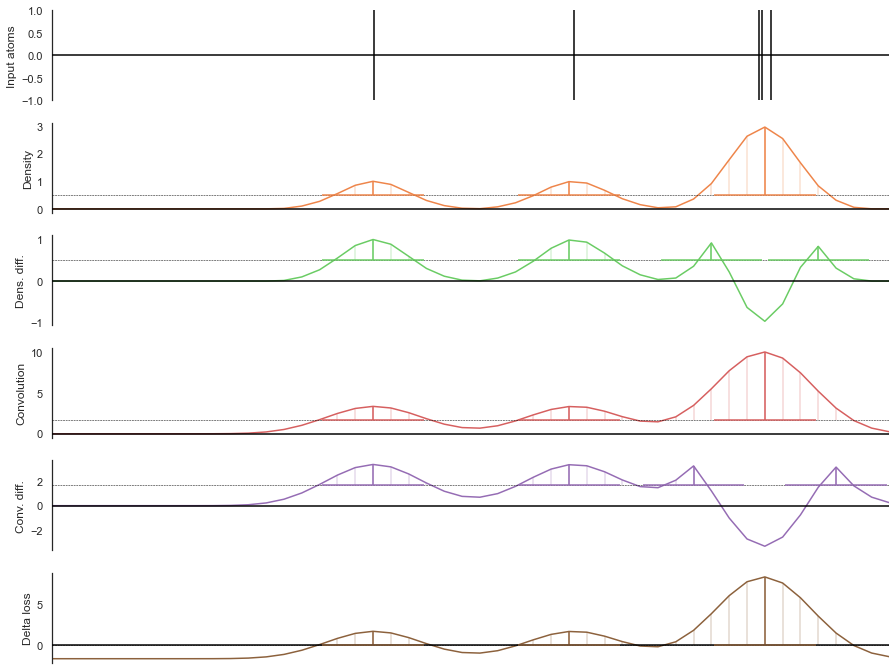

In [3]:
from scipy.signal import convolve

def get_next_atoms(points, values, threshold=None, min_dist=0):
    
    idx = np.argsort(-values, axis=None)
    points = points[idx]
    values = values[idx]
    
    if threshold is not None:
        above_thresh = values > threshold
        points = points[above_thresh]
        values = values[above_thresh]
    
    if min_dist > 0:
        
        min_dist2 = min_dist**2
        best_points = np.empty((0,1))
        best_values = np.empty((0,))
    
        for point, value in zip(points, values):
        
            dist2 = ((point - best_points)**2).sum(axis=-1)
            if all(dist2 > min_dist2):
                best_points = np.append(best_points, point[nax,...], axis=0)
                best_values = np.append(best_values, value[nax,...], axis=0)
                
        return best_points, best_values, points, values
    else:  
        return points, values, points, values

grid_dimension = 23.5
grid_points = get_grid_points(0.0, grid_dimension, resolution)[:,nax]

#atom_coords = np.array([-8.75, -5.0, 1 - radius/2, 1 + radius/2, 7.0, 7.0+bond_length])
n_atoms = np.random.randint(0, 10)
atom_coords = np.random.uniform(grid_points.min(), grid_points.max(), (n_atoms, 1))
#atom_coords = np.array([-1, 0, 1])[:,nax]*bond_length

density = get_atom_density(atom_coords[nax,:,:], atom_radius, grid_points[:,nax,:]).sum(axis=-1)

# gen_loss = (error^2).sum()/2
# 2*gen_loss = (error^2).sum()
# 2*gen_loss/N = (error^2).mean()
# 2*gen_loss/N = error_var, assuming bias = 0

error_var = 0.0
error = np.random.normal(0, np.sqrt(error_var), density.shape)
density += error
print((error**2).mean())

kernel_max = kernel.max()
density_diff = kernel_max - np.abs(kernel_max - density)

density_norm2 = (density**2).sum()
kernel_norm2  = (kernel**2).sum()
conv = convolve(density, kernel, mode='same')

density_sum = density.sum()
kernel_sum = kernel.sum()
n_atoms_est = density_sum / kernel_sum
print(n_atoms_est)

loss_init = density_norm2/2
loss_conv = density_norm2/2 + kernel_norm2/2 - conv # polarization identity
delta_loss = -(loss_conv - loss_init)

#conv_diff = abs(dloss_conv + kernel_norm2)
#conv_diff = abs(loss_conv - loss_init + kernel_norm2)
#conv_diff = abs(loss_conv - density_norm2 + kernel_norm2)
#conv_diff = abs(density_norm2 + kernel_norm2 - 2*conv - density_norm2 + kernel_norm2)
#conv_diff = abs(kernel_norm2 - 2*conv + kernel_norm2)
conv_diff = kernel_norm2 - np.abs(kernel_norm2 - conv)

loss_actual = ((density - get_atom_density(grid_points[nax,:,:], atom_radius, grid_points[:,nax,:]))**2).sum(axis=-1)
dloss_actual = loss_actual - loss_init

metric_names = ['Input atoms', 'Density', 'Dens. diff.', 'Convolution', 'Conv. diff.', 'Delta loss']
metrics      = [None,           density,   density_diff,  conv,          conv_diff,     delta_loss ]
thresholds   = [None,           0.5,      0.5,           kernel_norm2/2, kernel_norm2/2, 0       ]

n_rows = len(metrics)
height = 2
width = 15
fig, axes = plt.subplots(n_rows, 1, figsize=(width, n_rows*height),
                         gridspec_kw=dict(hspace=0.25))

for i, (name, metric, thresh) in enumerate(zip(metric_names, metrics, thresholds)):
    
    ax = axes[i]
    if i > 0:
        ax.plot(grid_points, metric, color=colors[i])
        y_min, y_max = ax.get_ylim()
        y_min = min(0, y_min)
        y_max = max(0, y_max)
        
        min_dist = 1.5*atom_radius
        atom_coords, values, atom_coords2, values2 = get_next_atoms(grid_points, metric, thresh, min_dist)
        
        ax.vlines(atom_coords2, thresh, values2, color=colors[i], linewidth=1.5, alpha=0.25)
        ax.vlines(atom_coords,  thresh, values,  color=colors[i], linewidth=1.5)
        for ac in atom_coords:
            ax.hlines(thresh, ac - min_dist/2, ac + min_dist/2, color=colors[i], linewidth=1.5, zorder=20)
    else:
        y_min, y_max = -1, 1
        ax.vlines(atom_coords, y_min, y_max, color='k')

    ax.set_xticks(grid_points)
    ax.set_xticklabels([])
    x_min, x_max = grid_points.min(), grid_points.max()
    ax.hlines(0, x_min, x_max, zorder=10)
    ax.hlines(thresh, x_min, x_max, linestyle='--', linewidth=0.5, zorder=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(name)
    ax.grid(False)

sns.despine(fig, top=True, bottom=True, right=True)
fig.tight_layout()

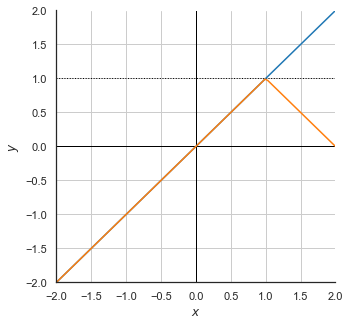

In [4]:
peak_value = 1.0
fig, ax = plt.subplots(figsize=(5,5))
x = np.linspace(-2, 2, 100)
y = peak_value - np.abs(peak_value - x)
ax.plot(x, x)
ax.plot(x, y)
ax.hlines(0, -2, 2, 'k', lw=1)
ax.vlines(0, -2, 2, 'k', lw=1)
ax.hlines(peak_value, -2, 2, linestyle=':', lw=1)
ax.grid(True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(fig)

In [5]:
expt_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\test_multi_atom\\csb_test_multi_atom.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\test_multi_atom\\crc_test_multi_atom.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\test_multi_atom\\csb_redo.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\test_multi_atom\\csb_debug.gen_metrics',
]
expt_param_names = ['expt_name', 'cluster']

expt_dfs = []
for expt_file in expt_files:
    expt_df = pd.read_csv(expt_file, sep=' ')
    cluster, expt_name = os.path.splitext(os.path.basename(expt_file))[0].split('_', 1)
    expt_df['expt_name'] = expt_name
    expt_df['cluster'] = cluster
    expt_dfs.append(expt_df)
    print(expt_file)
        
fit_df = pd.concat(expt_dfs)

c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (29,32,65,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\test_multi_atom\csb_test_multi_atom.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\test_multi_atom\crc_test_multi_atom.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (37,59,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\test_multi_atom\csb_redo.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\test_multi_atom\csb_debug.gen_metrics


In [6]:
from functools import lru_cache

job_param_names = ['code_version', 'job_name', 'variational', 'gen_loss_type', 'disc_loss_type', 'random_seed',
                   'fit_options', 'prior', 'random_rotation', 'multi_atom', 'apply_conv', 'estimate_types',
                   'constrain_types', 'threshold', 'peak_value', 'min_dist', 'interm_gd_iters', 'final_gd_iters',
                   'AE/VAE', 'posterior/prior', 'method', 'iteration']

ae_name_format = 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{threshold}_{peak_value}_{min_dist}_{interm_gd_iters}_{final_gd_iters}'
redo_ae_name_format = 'redo_ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_none'

old_ae_name_format = 'old_ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_none_{interm_gd_iters}_{final_gd_iters}'
new_ae_name_format = 'new_ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{threshold}_{peak_value}_{min_dist}_{interm_gd_iters}_{final_gd_iters}'


@lru_cache(100)
def parse_job_name(job_name):
    try:
        if job_name.startswith('redo') or job_name.startswith('old'):
            
            code_version = 'old'
            if job_name.startswith('redo'):
                job_params = parse.parse(redo_ae_name_format, job_name).named
            else:
                job_params = parse.parse(old_ae_name_format, job_name).named

            job_params['threshold'] = 0.0
            job_params['peak_value'] = 'inf'
            job_params['min_dist'] = 0.0
            if job_name.startswith('redo'):
                job_params['interm_gd_iters'] = 10
                job_params['final_gd_iters'] = 100
        else:
            code_version = 'new'
            if job_name.startswith('new'):
                job_params = parse.parse(new_ae_name_format, job_name).named
            else:
                job_params = parse.parse(ae_name_format, job_name).named

    except AttributeError:
        print(job_name)
        raise

    job_params['code_version'] = code_version
    job_params['job_name'] = job_name
    job_params['variational'] = False
    
    # default values for params not present in each name format
    if 'gen_loss_type' not in job_params:
        job_params['gen_loss_type'] = 'e'

    # parse fit_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior'] = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    job_params['multi_atom'] = 'M' in fit_options
    job_params['apply_conv'] = 'c' in fit_options
    job_params['estimate_types'] = 'e' in fit_options
    job_params['constrain_types'] = 't' in fit_options
    
    # convert data types of numeric params
    job_params['random_seed'] = int(job_params['random_seed'])
    job_params['iteration'] = int(job_params['iteration'])
    job_params['threshold'] = float(job_params['threshold'])
    job_params['peak_value'] = float(job_params['peak_value'])
    job_params['min_dist'] = float(job_params['min_dist'])
    job_params['interm_gd_iters'] = int(job_params['interm_gd_iters'])
    job_params['final_gd_iters'] = int(job_params['final_gd_iters'])
    
    # add other params
    job_params['AE/VAE'] = ['AE', 'VAE'][job_params['variational']]
    job_params['posterior/prior'] = ['posterior', 'prior'][job_params['prior']]
    job_params['method'] = ' '.join([job_params['AE/VAE'], job_params['posterior/prior']])

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = expt_param_names + job_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
expt_name,object,3,"[test_multi_atom, redo, debug]"
cluster,object,2,"[csb, crc]"
code_version,object,2,"[new, old]"
job_name,object,717,"[ae_disc_x_0_100000_r_0.0_1.0_1.0_0_0, ae_disc..."
variational,bool,1,[False]
gen_loss_type,object,1,[e]
disc_loss_type,object,1,[x]
random_seed,int64,1,[0]
fit_options,object,5,"[r, rc, ret, rM, rMc]"
prior,bool,1,[False]


In [7]:
from rdkit import Chem

@lru_cache(100)
def smi_to_ring_info(smi):
    
    if smi is not np.nan:
        mol = Chem.MolFromSmiles(smi)
    else:
        mol = None

    if mol is not None:
        rings = Chem.GetSymmSSSR(mol)
        n_rings = len(rings)
        ring_sizes = [len(r) for r in rings]
        if n_rings > 0:
            mean_ring_size = sum(ring_sizes) / n_rings
            min_ring_size = min(ring_sizes)
            max_ring_size = max(ring_sizes)
        else:
            mean_ring_size = np.nan
            min_ring_size = np.nan
            max_ring_size = np.nan
        n_3_rings = sum(1 for r in ring_sizes if r == 3)
        n_4_rings = sum(1 for r in ring_sizes if r == 4)
        n_5_rings = sum(1 for r in ring_sizes if r == 5)
        n_6_rings = sum(1 for r in ring_sizes if r == 6)
    else:
        n_rings = np.nan
        mean_ring_size = np.nan
        min_ring_size = np.nan
        max_ring_size = np.nan
        n_3_rings = np.nan
        n_4_rings = np.nan
        n_5_rings = np.nan
        n_6_rings = np.nan
    
    return pd.Series([
        n_rings, mean_ring_size, min_ring_size, max_ring_size,
        n_3_rings, n_4_rings, n_5_rings, n_6_rings
    ])

new_col_suffixes = ['n_rings', 'mean_ring_size', 'min_ring_size', 'max_ring_size', 
                    'n_3_rings', 'n_4_rings', 'n_5_rings', 'n_6_rings']

for prefix in ['lig', 'lig_fit_add', 'lig_gen_fit_add']:
    new_cols = [prefix + '_' + c for c in new_col_suffixes]
    fit_df[new_cols] = fit_df[prefix + '_SMILES'].apply(smi_to_ring_info)


In [8]:
fit_df['lig_fit_exact_types'] = (fit_df['lig_fit_type_diff'] == 0)
fit_df['lig_gen_fit_exact_types'] = (fit_df['lig_gen_fit_type_diff'] == 0)

fit_df['lig_fit_add_log_E'] = np.log10(fit_df['lig_fit_add_E'])
fit_df['lig_fit_add_min_log_E'] = np.log10(fit_df['lig_fit_add_min_E'])
fit_df['lig_gen_fit_add_log_E'] = np.log10(fit_df['lig_gen_fit_add_E'])
fit_df['lig_gen_fit_add_min_log_E'] = np.log10(fit_df['lig_gen_fit_add_min_E'])

fit_df['lig_fit_add_n_rings_diff'] = -(fit_df['lig_n_rings'] - fit_df['lig_fit_add_n_rings'])
fit_df['lig_fit_add_mean_ring_size_diff'] = -(fit_df['lig_mean_ring_size'] - fit_df['lig_fit_add_mean_ring_size'])
fit_df['lig_fit_add_min_ring_size_diff'] = -(fit_df['lig_min_ring_size'] - fit_df['lig_fit_add_min_ring_size'])
fit_df['lig_fit_add_max_ring_size_diff'] = -(fit_df['lig_max_ring_size'] - fit_df['lig_fit_add_max_ring_size'])
fit_df['lig_fit_add_n_3_rings_diff'] = -(fit_df['lig_n_3_rings'] - fit_df['lig_fit_add_n_3_rings'])
fit_df['lig_fit_add_n_4_rings_diff'] = -(fit_df['lig_n_4_rings'] - fit_df['lig_fit_add_n_4_rings'])
fit_df['lig_fit_add_n_5_rings_diff'] = -(fit_df['lig_n_5_rings'] - fit_df['lig_fit_add_n_5_rings'])
fit_df['lig_fit_add_n_6_rings_diff'] = -(fit_df['lig_n_6_rings'] - fit_df['lig_fit_add_n_6_rings'])

fit_df['lig_fit_add_ring_diff'] = (
    fit_df['lig_fit_add_n_3_rings_diff'].abs() +
    fit_df['lig_fit_add_n_4_rings_diff'].abs() +
    fit_df['lig_fit_add_n_5_rings_diff'].abs() +
    fit_df['lig_fit_add_n_6_rings_diff'].abs()
)

fit_df['lig_gen_fit_add_n_rings_diff'] = -(fit_df['lig_n_rings'] - fit_df['lig_gen_fit_add_n_rings'])
fit_df['lig_gen_fit_add_mean_ring_size_diff'] = -(fit_df['lig_mean_ring_size'] - fit_df['lig_gen_fit_add_mean_ring_size'])
fit_df['lig_gen_fit_add_min_ring_size_diff'] = -(fit_df['lig_min_ring_size'] - fit_df['lig_gen_fit_add_min_ring_size'])
fit_df['lig_gen_fit_add_max_ring_size_diff'] = -(fit_df['lig_max_ring_size'] - fit_df['lig_gen_fit_add_max_ring_size'])
fit_df['lig_gen_fit_add_n_3_rings_diff'] = -(fit_df['lig_n_3_rings'] - fit_df['lig_gen_fit_add_n_3_rings'])
fit_df['lig_gen_fit_add_n_4_rings_diff'] = -(fit_df['lig_n_4_rings'] - fit_df['lig_gen_fit_add_n_4_rings'])
fit_df['lig_gen_fit_add_n_5_rings_diff'] = -(fit_df['lig_n_5_rings'] - fit_df['lig_gen_fit_add_n_5_rings'])
fit_df['lig_gen_fit_add_n_6_rings_diff'] = -(fit_df['lig_n_6_rings'] - fit_df['lig_gen_fit_add_n_6_rings'])

fit_df['lig_gen_fit_add_ring_diff'] = (
    fit_df['lig_gen_fit_add_n_3_rings_diff'].abs() +
    fit_df['lig_gen_fit_add_n_4_rings_diff'].abs() +
    fit_df['lig_gen_fit_add_n_5_rings_diff'].abs() +
    fit_df['lig_gen_fit_add_n_6_rings_diff'].abs()
)

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
debug_params = ['multi_atom', 'threshold', 'min_dist', 'interm_gd_iters', 'final_gd_iters']

cols = [
    'lig_gen_L2_loss',
    'lig_fit_L2_loss',
    'lig_fit_n_atoms',
    'lig_fit_type_diff',
    'lig_fit_exact_types',
    'lig_fit_RMSD',
    'lig_fit_time',
    'lig_gen_fit_L2_loss',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_exact_types',
    'lig_gen_fit_RMSD',
    'lig_gen_fit_time',
]

old_debug_df = fit_df[
    (fit_df['expt_name'] == 'debug') &
    (fit_df['code_version'] == 'old') &
    (fit_df['multi_atom'])
].set_index(['array_idx', 'lig_name', 'sample_idx'] + debug_params)[cols]

new_debug_df = fit_df[
    (fit_df['expt_name'] == 'debug') &
    (fit_df['code_version'] == 'new') &
    (fit_df['multi_atom'])
].set_index(['array_idx', 'lig_name', 'sample_idx'] + debug_params)[cols]

(new_debug_df).reset_index().groupby(['array_idx', 'lig_name'] + debug_params)[cols].mean()

lig_gen_L2_loss  \
array_idx lig_name      multi_atom threshold min_dist interm_gd_iters final_gd_iters                    
1         O_0.0_0.0_0.0 True       0.0       0.0      0               10                     2.011590   
                                             0.5      0               10                     2.011589   
                                             1.0      0               10                     2.011589   
                                   0.1       0.0      0               10                     2.011589   
                                             0.5      0               10                     2.011590   
...                                                                                               ...   
3         103017026_14  True       0.8       1.5      1               10                    12.851695   
                                                      10              10                    12.851697   
                                             2.0      0               10                    12.851695   
                                                      1               10                    12.851698   
                                                      10              10                    12.851696   

                                                                                      lig_fit_L2_loss  \
array_idx lig_name      multi_atom threshold min_dist interm_gd_iters final_gd_iters                    
1         O_0.0_0.0_0.0 True       0.0       0.0      0               10                    13.582653   
                                             0.5      0               10                     0.009373   
                                             1.0      0               10                     0.009373   
                                   0.1       0.0      0               10                    13.582653   
                                             0.5      0               10                     0.009373   
...                                                                                               ...   
3         103017026_14  True       0.8       1.5      1               10                    69.767876   
                                                      10              10                   101.043946   
                                             2.0      0               10                    23.295941   
                                                      1               10                    74.637867   
                                                      10              10                   101.030744   

                                                                                      lig_fit_n_atoms  \
array_idx lig_name      multi_atom threshold min_dist interm_gd_iters final_gd_iters                    
1         O_0.0_0.0_0.0 True       0.0       0.0      0               10                     0.000000   
                                             0.5      0               10                     1.000000   
                                             1.0      0               10                     1.000000   
                                   0.1       0.0      0               10                     0.000000   
                                             0.5      0               10                     1.000000   
...                                                                                               ...   
3         103017026_14  True       0.8       1.5      1               10                    18.333333   
                                                      10              10                    16.000000   
                                             2.0      0               10                    21.966667   
                                                      1               10                    17.966667   
                                                      10              10                    16

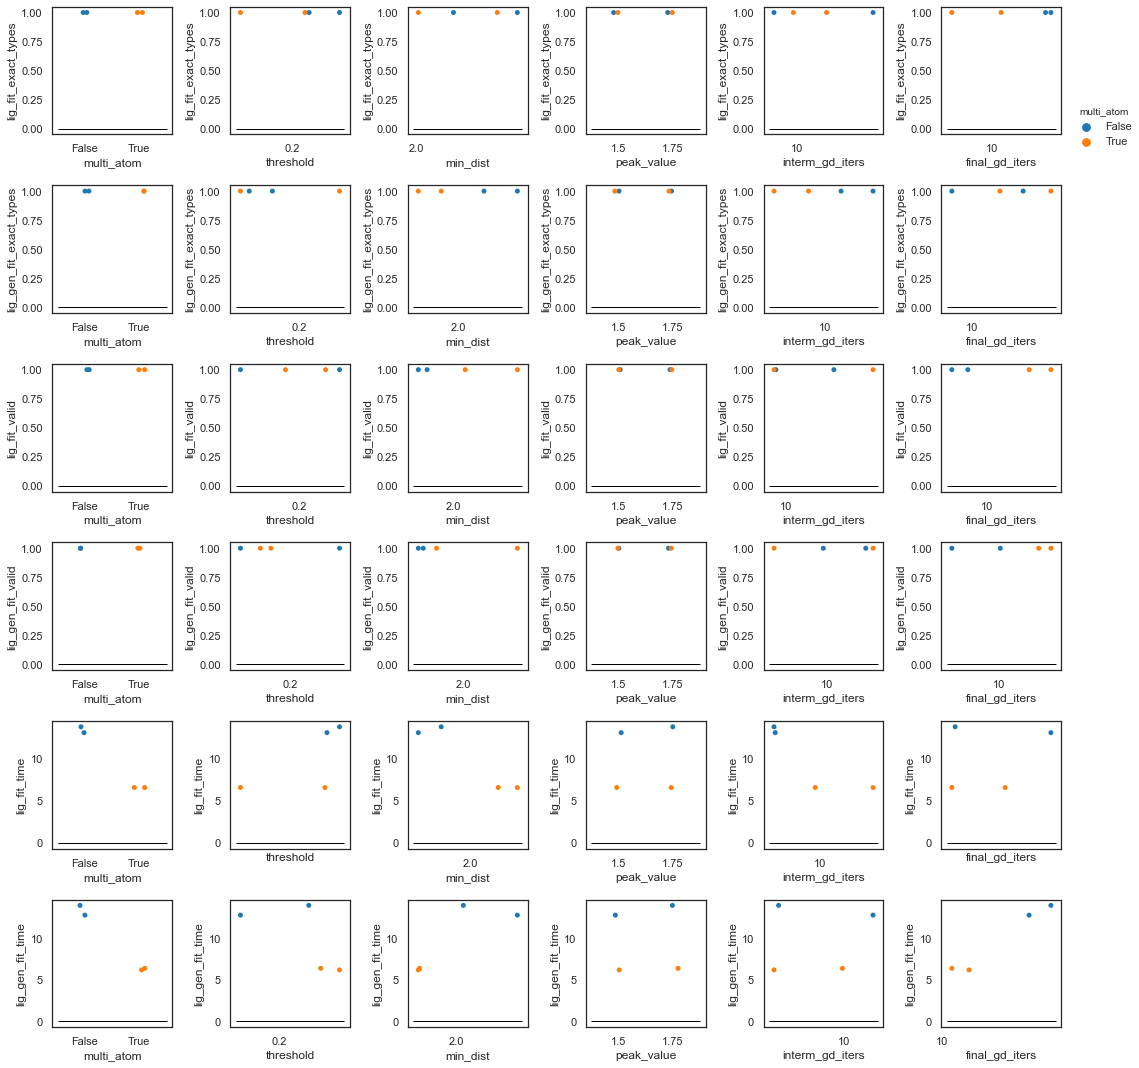

In [10]:
from results import plot_strips

x = [
    'multi_atom',
    'threshold',
    'min_dist',
    'peak_value',
    'interm_gd_iters',
    'final_gd_iters',
]
y = [
    #'lig_gen_L2_loss',
    
    ##'lig_fit_L2_loss'
    #'lig_fit_n_atoms',
    #'lig_fit_type_diff', 'lig_gen_fit_type_diff',
    'lig_fit_exact_types', 'lig_gen_fit_exact_types',
    'lig_fit_valid', 'lig_gen_fit_valid',
    ##'lig_fit_RMSD',
    'lig_fit_time', 'lig_gen_fit_time'
    
    #'lig_gen_fit_L2_loss',
    #'lig_gen_fit_n_atoms',
    
    #'lig_gen_fit_RMSD',
    
]
kwargs = dict(hue='multi_atom')

plot_df = fit_df[
    (fit_df['expt_name'] == 'debug') &
    (fit_df['code_version'] == 'new') &
    #(fit_df['multi_atom']) &
    (fit_df['threshold'] == 0.2) &
    (fit_df['min_dist'] == 2.0) &
    (fit_df['peak_value'].isin({1.50, 1.75})) &
    (fit_df['interm_gd_iters'] == 10) &
    (fit_df['final_gd_iters'] == 10) &
    (fit_df['lig_name'] == '103017026_14')
].groupby(['array_idx', 'lig_name'] + x)[y].mean().groupby(x).mean()

fig = plot_strips('debug_strips.png', plot_df, x=x, y=y,
                  height=2.5, width=2.5, strip=True, **kwargs)

In [11]:
lig_names = fit_df[(fit_df['expt_name'] == 'redo')].sort_values('array_idx')['lig_name'].unique()

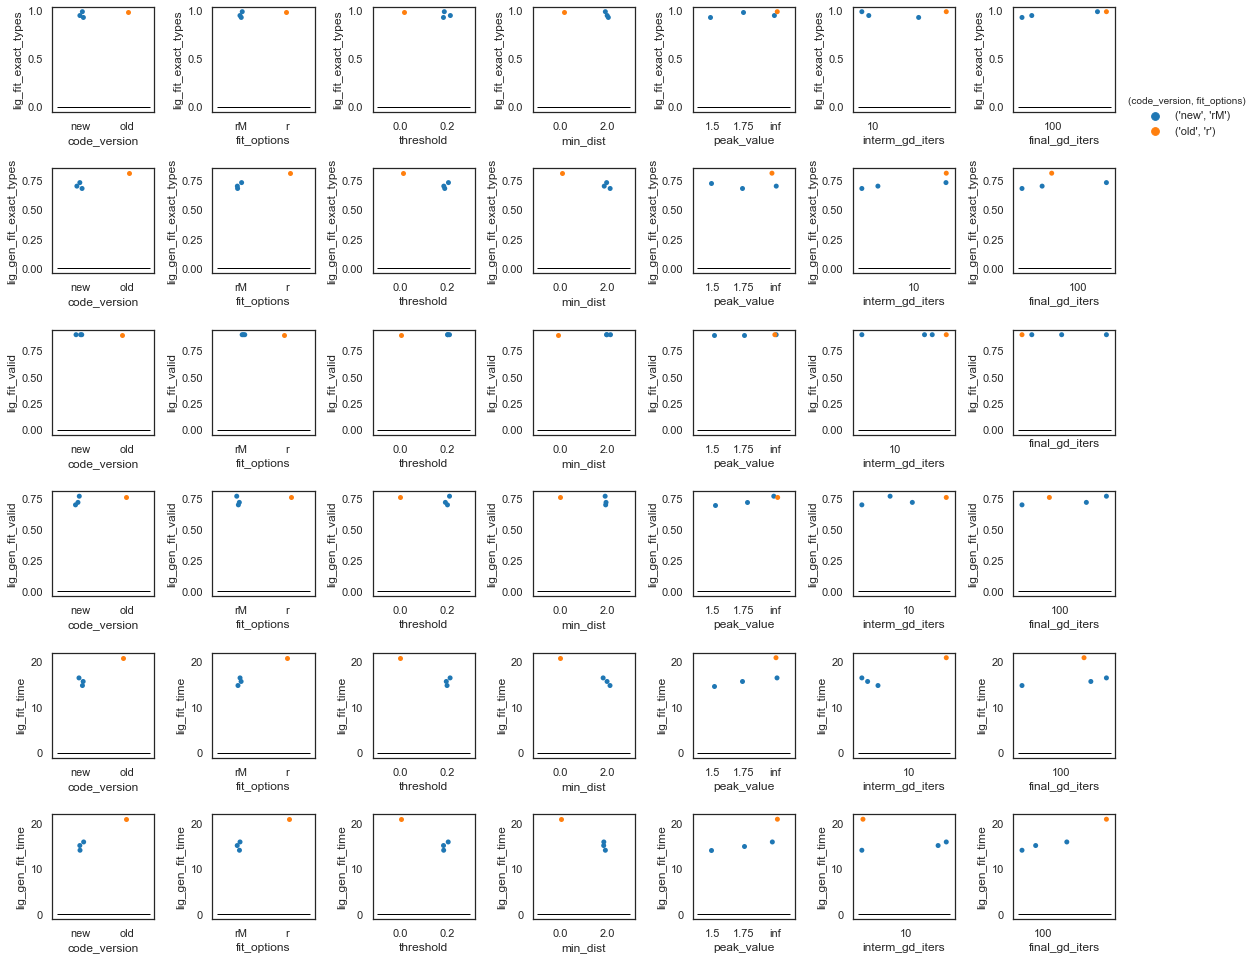

In [12]:
from results import plot_strips, aggregate_data, add_group_column

x = [
    'code_version',
    'fit_options',
    'threshold',
    'min_dist',
    'peak_value',
    'interm_gd_iters',
    'final_gd_iters',
]
y = [
    #'lig_gen_L2_loss',
    
    ##'lig_fit_L2_loss'
    #'lig_fit_n_atoms',
    #'lig_fit_type_diff', 'lig_gen_fit_type_diff',
    'lig_fit_exact_types', 'lig_gen_fit_exact_types',
    'lig_fit_valid', 'lig_gen_fit_valid',
    ##'lig_fit_RMSD',
    'lig_fit_time', 'lig_gen_fit_time'
    
    #'lig_gen_fit_L2_loss',
    #'lig_gen_fit_n_atoms',
    
    #'lig_gen_fit_RMSD',
    
]

plot_df = fit_df[
    (
        (
            (fit_df['expt_name'] == 'redo')
        ) |
        (
            (fit_df['expt_name'] == 'test_multi_atom') &
            (fit_df['multi_atom']) &
            (fit_df['threshold'] == 0.2) &
            (fit_df['min_dist'] == 2.0) &
            #(fit_df['peak_value'].isin({1.50, 1.75})) &
            (fit_df['interm_gd_iters'] == 10) &
            #(fit_df['final_gd_iters'] == 10) &
            True
        )
    ) &
    (fit_df['lig_name'].isin(lig_names[:10]))
].groupby(x).mean().reset_index()

hue = add_group_column(plot_df, ['code_version', 'fit_options'])

kwargs = dict(hue=hue)

fig = plot_strips('test_multi_atom_strips.png', plot_df, x=x, y=y,
                  height=2.25, width=2.25, strip=True, **kwargs)

In [13]:
tab_df = fit_df[
    (fit_df['expt_name'].isin({'redo', 'test_multi_atom'})) &
    #(fit_df['cluster'] == 'csb') &
    (fit_df['array_idx'] <= 10)
]

tab_df.groupby(['job_name', 'cluster']).mean().sort_values('lig_fit_exact_types', ascending=False)[y].head(5)

,,lig_fit_exact_types,lig_gen_fit_exact_types,lig_fit_valid,lig_gen_fit_valid,lig_fit_time,lig_gen_fit_time
job_name,cluster,,,,,,
ae_disc_x_0_100000_ret_0.5_1.0_1.0_0_100,csb,1.0,0.47,0.88,0.48,16.194442,14.603594
ae_disc_x_0_100000_ret_0.5_1.25_1.0_0_0,csb,1.0,0.52,0.25,0.08,14.292730,13.760891
ae_disc_x_0_100000_ret_0.4_1.25_1.0_0_100,csb,1.0,0.59,0.88,0.63,18.641869,18.173208
ae_disc_x_0_100000_ret_0.4_1.5_1.0_0_0,csb,1.0,0.57,0.30,0.15,18.897871,18.335575
ae_disc_x_0_100000_ret_0.4_1.5_1.0_0_100,csb,1.0,0.57,0.88,0.60,18.328264,17.777956


In [14]:
tab_df.groupby(['job_name', 'cluster']).mean().sort_values('lig_gen_fit_exact_types', ascending=False)[y].head(5)

,,lig_fit_exact_types,lig_gen_fit_exact_types,lig_fit_valid,lig_gen_fit_valid,lig_fit_time,lig_gen_fit_time
job_name,cluster,,,,,,
ae_disc_x_0_100000_r_0.1_1.5_0.0_10_100,crc,0.988889,0.866667,0.888889,0.777778,14.763210,14.753821
ae_disc_x_0_100000_r_0.0_1.5_0.0_10_100,crc,0.990000,0.830000,0.900000,0.750000,14.249373,14.231973
redo_ae_disc_x_0_100000_r_none,csb,0.990000,0.810000,0.900000,0.760000,20.835488,20.948550
ae_disc_x_0_100000_r_0.0_inf_0.0_10_100,crc,0.990000,0.810000,0.900000,0.750000,14.719471,14.647558
ae_disc_x_0_100000_r_0.1_inf_0.0_10_100,crc,0.990000,0.810000,0.900000,0.750000,14.665018,14.634976


c:\users\mtr22\code\miniconda3\lib\site-packages\matplotlib\colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


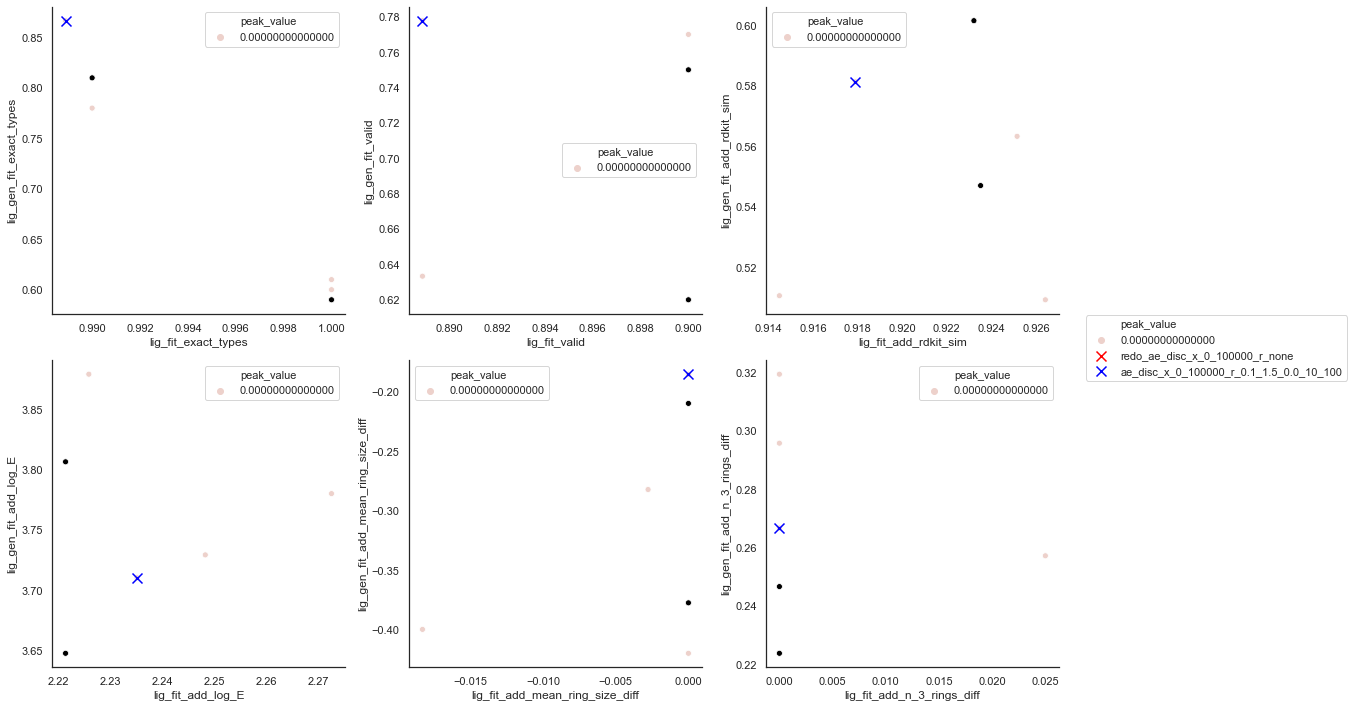

In [15]:

plot_df = fit_df[
    (fit_df['expt_name'].isin({'test_multi_atom', 'redo'})) &
    #(fit_df['cluster'] == 'csb') &
    (~fit_df['apply_conv']) &
    (fit_df['threshold'] == 0.1) &
    (fit_df['min_dist'] == 0.0) &
    (fit_df['array_idx'] <= 10) &
    (fit_df['lig_gen_fit_time'] < 100)
].groupby('job_name').mean().reset_index()

xys = [
    ('lig_fit_exact_types', 'lig_gen_fit_exact_types'),
    ('lig_fit_valid', 'lig_gen_fit_valid'),
    ('lig_fit_add_rdkit_sim', 'lig_gen_fit_add_rdkit_sim'),
    ('lig_fit_add_log_E', 'lig_gen_fit_add_log_E'),
    ('lig_fit_add_mean_ring_size_diff', 'lig_gen_fit_add_mean_ring_size_diff'),
    ('lig_fit_add_n_3_rings_diff', 'lig_gen_fit_add_n_3_rings_diff'),
]

height = 5
width = 5
n_plots = len(xys)
n_cols = 3
n_rows = n_plots // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*width, n_rows*height))

job_names = [
    'redo_ae_disc_x_0_100000_r_none',
    'ae_disc_x_0_100000_r_0.1_1.5_0.0_10_100',
    #'ae_disc_x_0_100000_r_0.4_inf_1.0_0_100',
    #'ae_disc_x_0_100000_r_0.4_inf_1.0_1_100',
    #'ae_disc_x_0_100000_r_0.4_inf_1.0_10_100',
]
colors = ['r', 'b']

old_job_name = 'ae_disc_x_0_100000_r_none'
old_row = dict(
    lig_fit_exact_types          = 0.993878,
    lig_gen_fit_exact_types      = 0.712245,
    lig_fit_valid                = 0.959184,
    lig_gen_fit_valid            = 0.687755,
    lig_fit_add_rdkit_sim        = 0.866303,
    lig_gen_fit_add_rdkit_sim    = 0.590055,
)

for ax, (x, y) in zip(axes.flatten(), xys):
    sns.scatterplot(x=x, y=y, hue='peak_value', data=plot_df, ax=ax)
    
    for job_name, color in zip(job_names, colors):
        row = plot_df[plot_df['job_name'] == job_name]
        ax.scatter(row[x], row[y], s=100, marker='x', color=color, zorder=100, label=job_name)

    #ax.scatter(old_row[x], old_row[y], s=100, marker='x', color='k', zorder=100, label=old_job_name)
    
#[(ax.set_xlim(0, 1), ax.set_ylim(0, 1)) for ax in axes]

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout()

sns.despine(fig)

In [16]:
fit_df.groupby('expt_name')[['lig_gen_L2_loss', 'lig_est_type_diff', 'lig_gen_est_type_diff', 'iteration']].describe().stack()

lig_gen_L2_loss  lig_est_type_diff  \
expt_name                                                   
debug           count      5630.000000           0.000000   
                mean          5.198495                NaN   
                std           5.473861                NaN   
                min           0.630341                NaN   
                25%           0.848929                NaN   
                50%           2.011588                NaN   
                75%          11.775106                NaN   
                max          14.608708                NaN   
redo            count      1000.000000           0.000000   
                mean         22.272997                NaN   
                std          12.951367                NaN   
                min           2.557023                NaN   
                25%          14.576673                NaN   
                50%          19.319702                NaN   
                75%          26.302693                NaN   
                max         123.776230                NaN   
test_multi_atom count    277240.000000       76300.000000   
                mean         21.939352           0.004251   
                std          12.611485           0.024448   
                min           2.557019           0.000669   
                25%          14.467972           0.002025   
                50%          19.189180           0.002357   
                75%          25.833082           0.002771   
                max         123.776306           0.581075   

                       lig_gen_est_type_diff  iteration  
expt_name                                                
debug           count               0.000000     5630.0  
                mean                     NaN   100000.0  
                std                      NaN        0.0  
                min                      NaN   100000.0  
                25%                      NaN   100000.0  
                50%                      NaN   100000.0  
                75%                      NaN   100000.0  
                max                      NaN   100000.0  
redo            count               0.000000     1000.0  
                mean                     NaN   100000.0  
                std                      NaN        0.0  
                min                      NaN   100000.0  
                25%                      NaN   100000.0  
                50%                      NaN   100000.0  
                75%                      NaN   100000.0  
                max                      NaN   100000.0  
test_multi_atom count           76300.000000   277240.0  
                mean                2.159303   100000.0  
                std                 0.669437        0.0  
                min                 0.914163   100000.0  
                25%                 1.704506   100000.0  
                50%                 2.051060   100000.0  
                75%                 2.475035   100000.0  
                max                 6.136003   100000.0

c:\users\mtr22\code\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\mtr22\code\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\mtr22\code\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\mtr22\code\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\mtr22\code\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


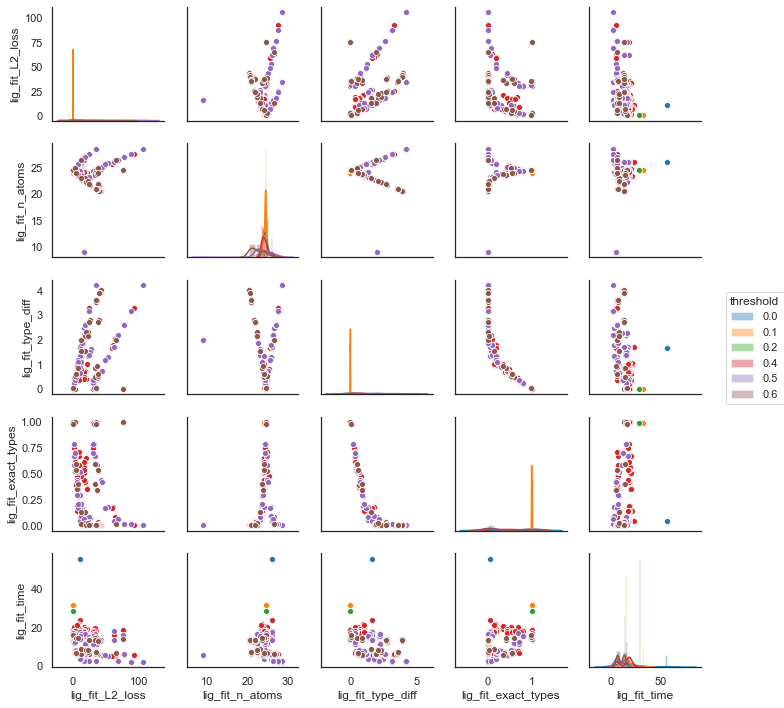

In [17]:
from results import plot_corr
from collections import defaultdict

plot_df = fit_df[
    (fit_df['expt_name'] == 'test_multi_atom') &
    (fit_df['array_idx'] <= 10) &
    (~fit_df['apply_conv'])
].copy().groupby(param_names).mean().reset_index().sort_values('expt_name', ascending=False)

hue = 'threshold' #add_group_column(plot_df, ['multi_atom', 'estimate_types'])

y = [
    'lig_fit_L2_loss',
    'lig_fit_n_atoms',
    'lig_fit_type_diff',
    'lig_fit_exact_types',
    'lig_fit_time',
]

fig = plot_corr('test_multi_atom_corr.png', plot_df, x=y, y=y, hue=hue,
                height=2, width=2)

In [18]:
old_row = dict(
    lig_fit_exact_types          = 0.993878,
    lig_gen_fit_exact_types      = 0.712245,
    lig_fit_valid                = 0.959184,
    lig_gen_fit_valid            = 0.687755,
    lig_fit_add_rdkit_sim        = 0.866303,
    lig_gen_fit_add_rdkit_sim    = 0.590055,
)

In [19]:
cols = [
    'lig_gen_L2_loss', 'lig_n_atoms',
    'lig_fit_type_diff', 'lig_gen_fit_type_diff',
    'lig_fit_exact_types', 'lig_gen_fit_exact_types',
    'lig_fit_valid', 'lig_gen_fit_valid',
    'lig_fit_add_rdkit_sim', 'lig_gen_fit_add_rdkit_sim',
    'lig_fit_time', 'lig_gen_fit_time',
    'lig_fit_RMSD', 'lig_gen_fit_RMSD',
]
fit_df[
    (fit_df['job_name'] == 'ae_disc_x_0_100000_ret_0.4_inf_1.0_10_100') &
    (fit_df['array_idx'] <= 100)
][cols].mean()

lig_gen_L2_loss              22.272997
lig_n_atoms                  27.100000
lig_fit_type_diff             1.208000
lig_gen_fit_type_diff         2.666000
lig_fit_exact_types           0.189000
lig_gen_fit_exact_types       0.049000
lig_fit_valid                 0.696000
lig_gen_fit_valid             0.324000
lig_fit_add_rdkit_sim         0.613795
lig_gen_fit_add_rdkit_sim     0.413271
lig_fit_time                 21.827071
lig_gen_fit_time             20.839831
lig_fit_RMSD                  0.004623
lig_gen_fit_RMSD              0.210328
dtype: float64

In [20]:
fit_df[
    (fit_df['job_name'] == 'ae_disc_x_0_100000_r_0.4_inf_1.0_10_100') &
    (fit_df['array_idx'] <= 100)
].groupby(['lig_name', 'array_idx'])[cols].mean().head()

,,lig_gen_L2_loss,lig_n_atoms,lig_fit_type_diff,lig_gen_fit_type_diff,lig_fit_exact_types,lig_gen_fit_exact_types,lig_fit_valid,lig_gen_fit_valid,lig_fit_add_rdkit_sim,lig_gen_fit_add_rdkit_sim,lig_fit_time,lig_gen_fit_time,lig_fit_RMSD,lig_gen_fit_RMSD
lig_name,array_idx,,,,,,,,,,,,,,
103017026_14,59,12.851694,24.0,0.9,1.1,0.1,0.2,1.0,0.8,0.625861,0.573112,19.853982,19.988341,0.000567,0.174858
103505640_0,41,14.623325,22.0,0.0,1.8,1.0,0.0,1.0,0.0,1.000000,0.383445,15.734669,14.595163,0.000594,NaN
103604119_6,64,15.447511,24.0,0.8,0.9,0.2,0.1,0.2,0.4,0.636985,0.445933,16.941274,17.264587,0.002040,0.176856
1067897_7,46,16.573400,29.0,1.8,2.2,0.0,0.0,0.8,0.6,0.382737,0.295016,28.523852,28.539192,NaN,NaN
1096408_3,25,14.212828,24.0,1.2,2.0,0.2,0.0,0.3,0.6,0.528644,0.326963,15.503598,15.626961,0.000656,NaN


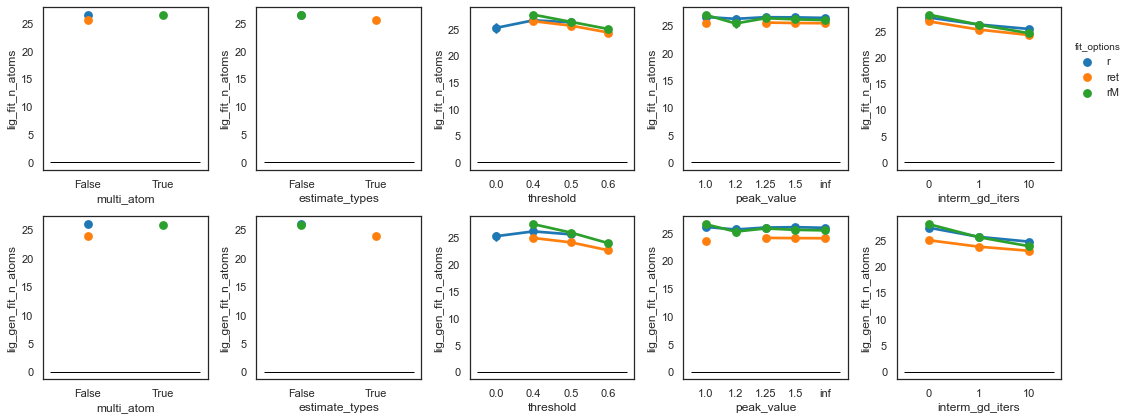

In [21]:
#sns.color_palette('pastel')

plot_df = fit_df[
    (fit_df['expt_name'] == 'test_multi_atom') & 
    #(fit_df['multi_atom'] == False) & 
    (fit_df['apply_conv'] == False) & 
    (fit_df['final_gd_iters'] == 0)
].copy()

x = ['multi_atom', 'estimate_types', 'threshold', 'peak_value', 'interm_gd_iters']

for x_ in x:
    other_cols = [ox for ox in x if x_ != ox]
    add_group_column(plot_df, other_cols)
    
hue = add_group_column(plot_df, ['multi_atom', 'estimate_types'])

kwargs = dict(hue='fit_options')
    
y = ['lig_fit_n_atoms', 'lig_gen_fit_n_atoms']

fig = plot_strips('test_multi_atom_fit_n_atoms_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

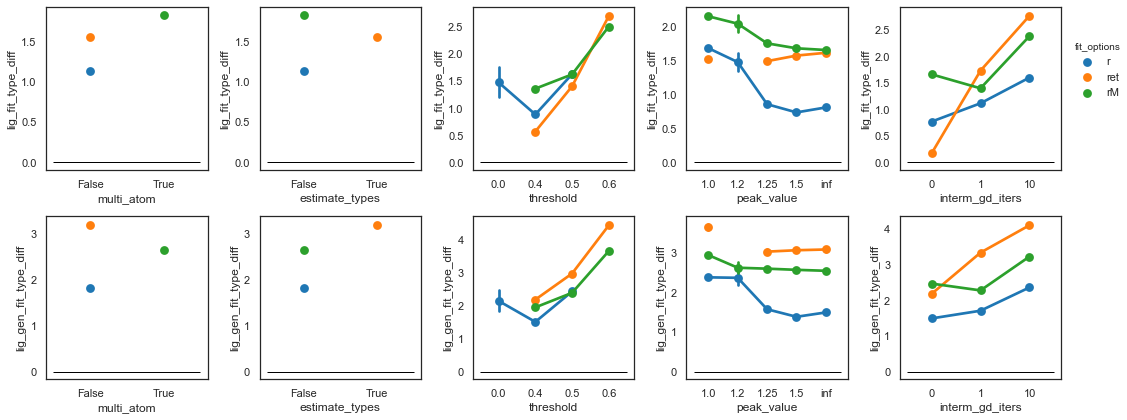

In [22]:
y = ['lig_fit_type_diff', 'lig_gen_fit_type_diff']

fig = plot_strips('test_multi_atom_fit_type_diff_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

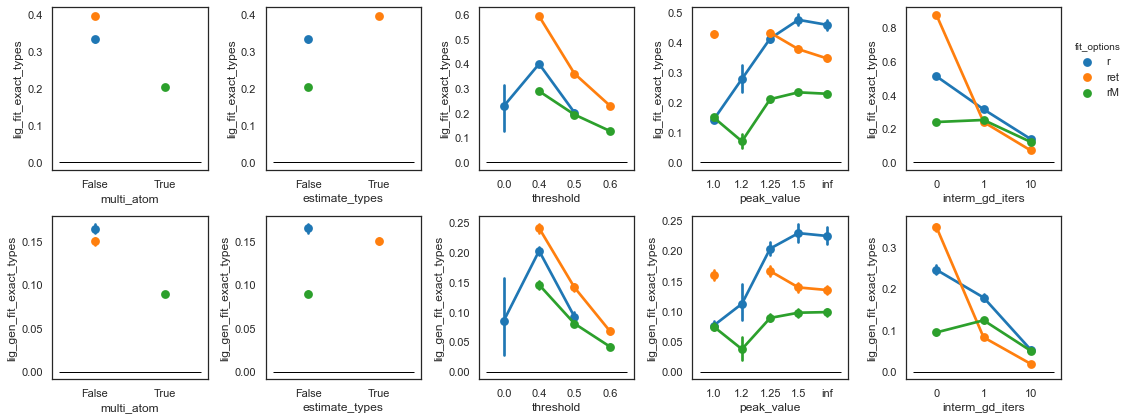

In [23]:
y = ['lig_fit_exact_types', 'lig_gen_fit_exact_types']

fig = plot_strips('test_multi_atom_fit_exact_types_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

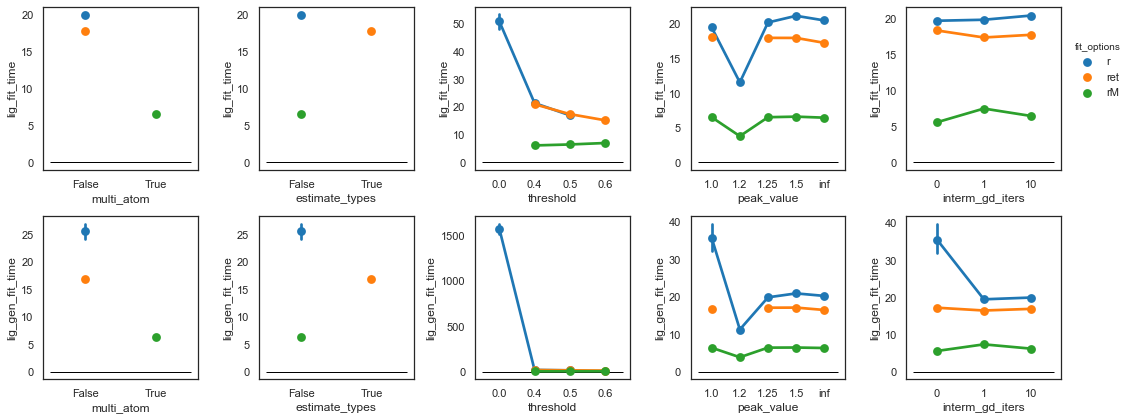

In [24]:
y = ['lig_fit_time', 'lig_gen_fit_time']

fig = plot_strips('test_multi_atom_fit_time_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

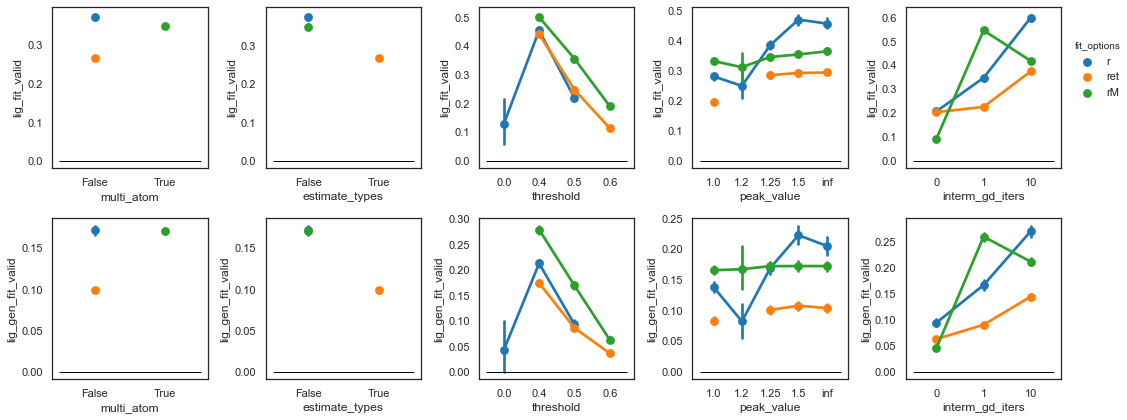

In [25]:
y = ['lig_fit_valid', 'lig_gen_fit_valid']

fig = plot_strips('test_multi_atom_fit_valid_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

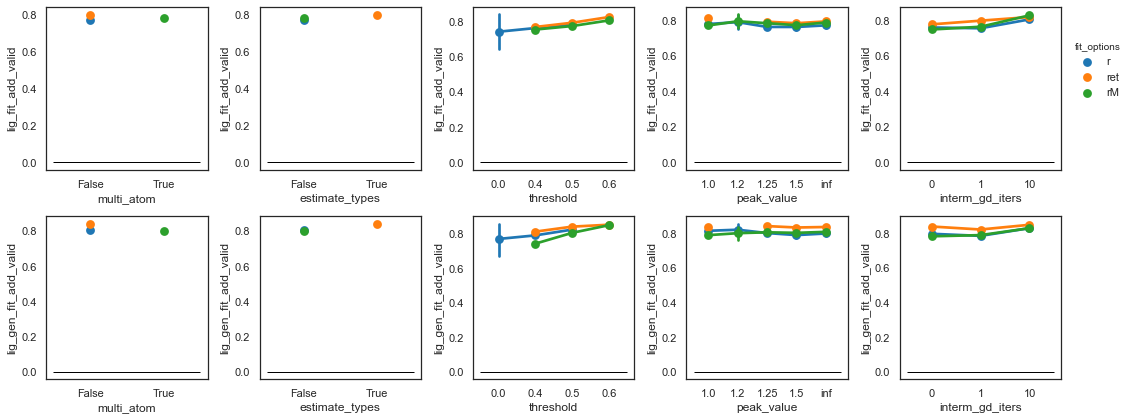

In [26]:
y = ['lig_fit_add_valid', 'lig_gen_fit_add_valid']

fig = plot_strips('test_multi_atom_fit_add_valid_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

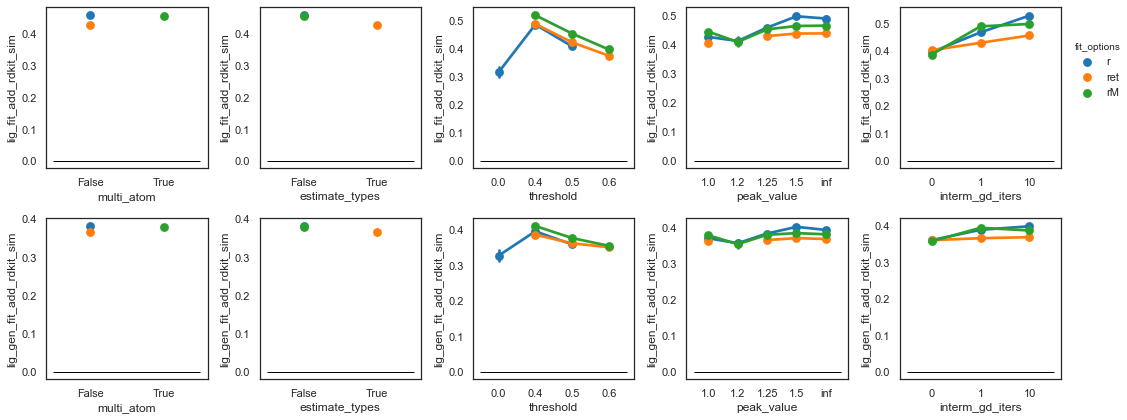

In [27]:
y = ['lig_fit_add_rdkit_sim', 'lig_gen_fit_add_rdkit_sim']

fig = plot_strips('test_multi_atom_fit_add_rdkit_sim_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

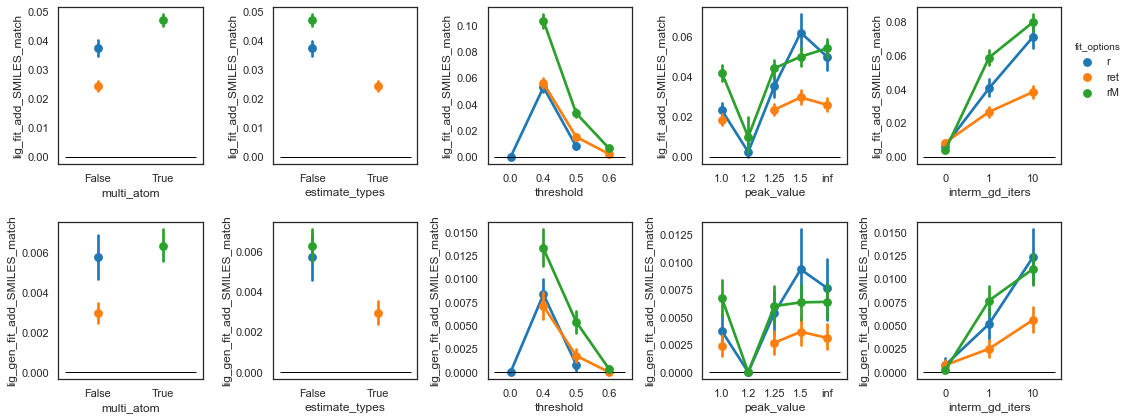

In [28]:
y = ['lig_fit_add_SMILES_match', 'lig_gen_fit_add_SMILES_match']

fig = plot_strips('test_multi_atom_fit_add_SMILES_match_strips.png', plot_df, x=x, y=y,
                  n_cols=len(x), height=3, width=15/len(x), point=True, **kwargs)

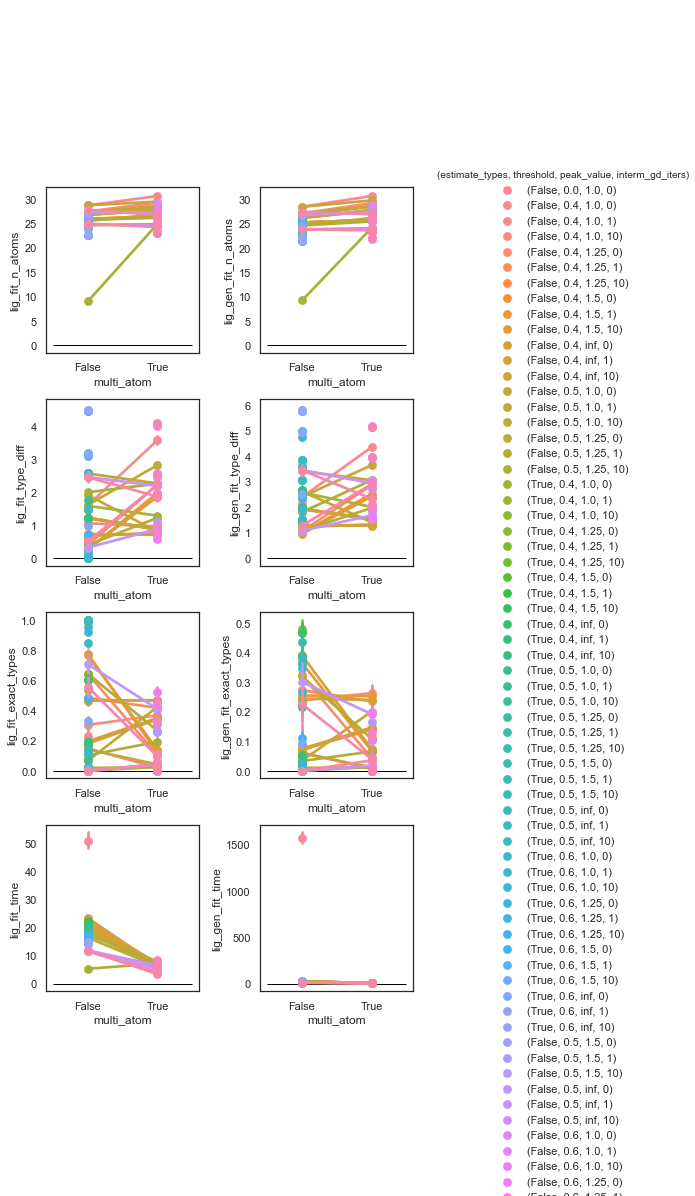

In [29]:
from results import plot_strips

params = ['multi_atom', 'estimate_types', 'threshold', 'peak_value', 'interm_gd_iters']
y = [
    'lig_fit_n_atoms', 'lig_gen_fit_n_atoms',
    'lig_fit_type_diff', 'lig_gen_fit_type_diff',
    'lig_fit_exact_types', 'lig_gen_fit_exact_types',
    'lig_fit_time', 'lig_gen_fit_time'
]

x = ['multi_atom']

hue = add_group_column(plot_df, [p for p in params if p not in x])

fig = plot_strips('multi_atom_strips.png', plot_df, x=x, y=y, hue=hue,
                  n_cols=2, height=3, width=3, point=True, lgd_h=1.2)


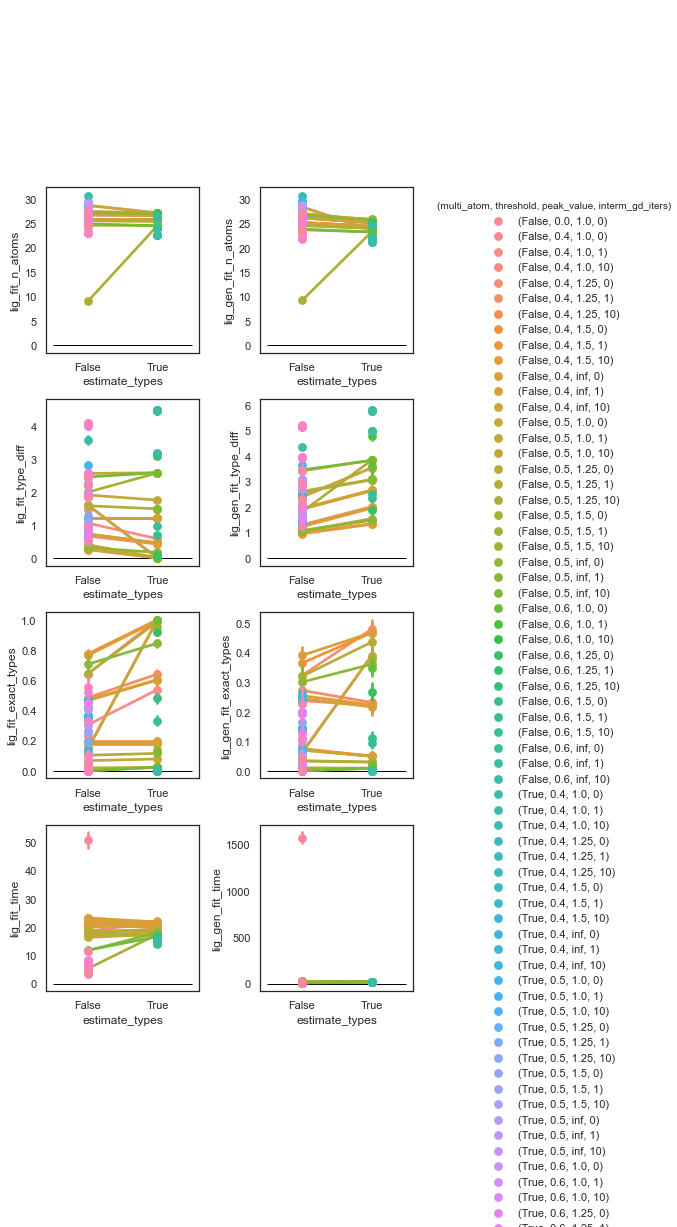

In [30]:
x = ['estimate_types']

hue = add_group_column(plot_df, [p for p in params if p not in x])

fig = plot_strips('estimate_types_strips.png', plot_df, x=x, y=y, hue=hue,
                  n_cols=2, height=3, width=3, point=True, lgd_h=1.2)


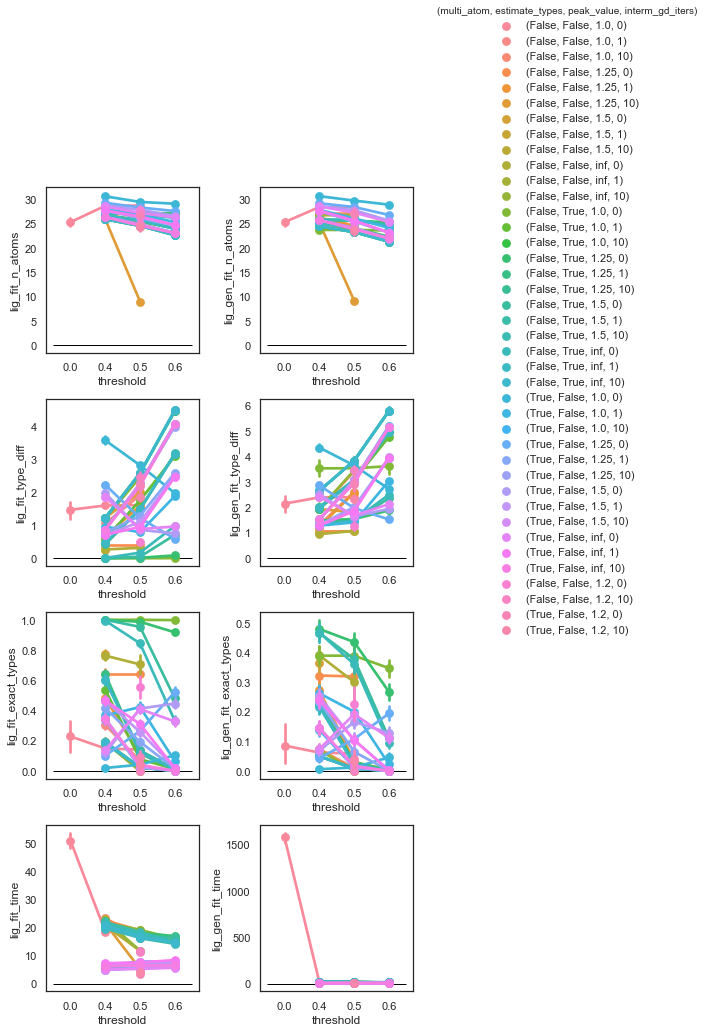

In [31]:
x = ['threshold']

hue = add_group_column(plot_df, [p for p in params if p not in x])

fig = plot_strips('test_multi_atom_strips.png', plot_df, x=x, y=y, hue=hue,
                  n_cols=2, height=3, width=3, point=True, lgd_h=1.2)

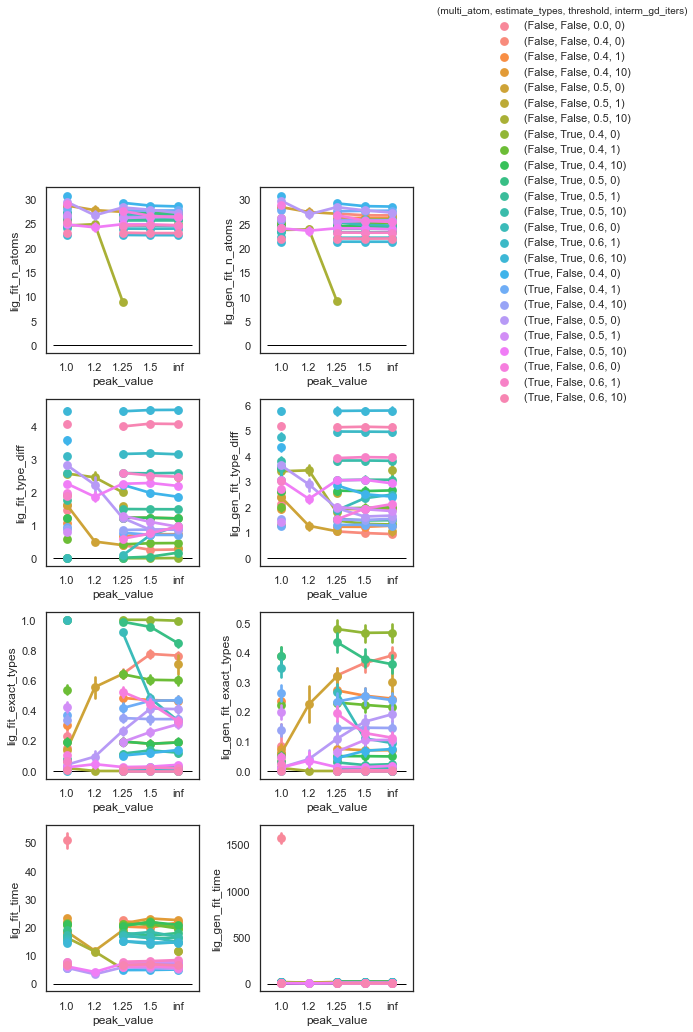

In [32]:
x = ['peak_value']

hue = add_group_column(plot_df, [p for p in params if p not in x])

fig = plot_strips('test_multi_atom_strips.png', plot_df, x=x, y=y, hue=hue,
                  n_cols=2, height=3, width=3, point=True, lgd_h=1.2)


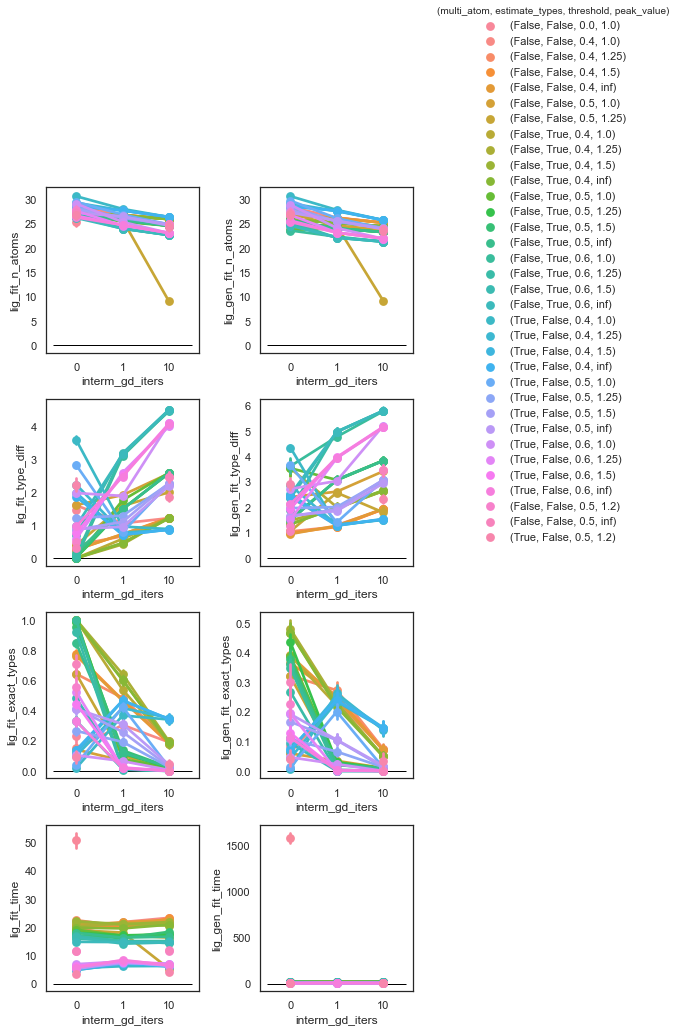

In [33]:
x = ['interm_gd_iters']

hue = add_group_column(plot_df, [p for p in params if p not in x])

fig = plot_strips('test_multi_atom_strips.png', plot_df, x=x, y=y, hue=hue,
                  n_cols=2, height=3, width=3, point=True, lgd_h=1.2)


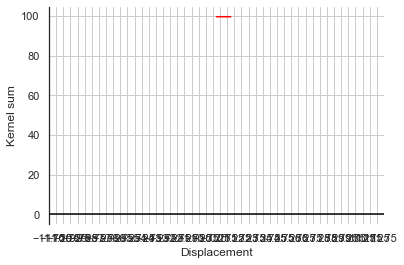

In [34]:
def get_grid_points(shape, center, resolution):
    shape = np.array(shape)
    center = np.array(center)
    resolution = np.array(resolution)
    origin = center - resolution*(shape - 1)/2.0
    indices = np.array(list(np.ndindex(*shape)))
    return origin + resolution*indices

#atom_radius = 0.37 # hydrogen
atom_radius = 1.2 # smallest radius in atom type scheme
atom_radius = 1.9 # carbon

size = 48
shape = (size, size, size)

center = np.zeros(3)
resolution = 0.5

grid_points = get_grid_points(shape, center, resolution)

nax = np.newaxis

v = np.array([1, 0, 0])

x = np.linspace(0, 1, 100)
centers = center[nax,:] + v[nax,:] * x[:,nax]

y = get_atom_density(centers[:,nax], atom_radius, grid_points[nax,:]).sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, color=colors[0])
ax.set_xticks(np.arange(x_min, x_max+resolution, resolution))
x_min, x_max = ax.get_xlim()
ax.hlines(0, x_min, x_max, zorder=10)
ax.set_xlim(x_min, x_max)
ax.set_xlabel('Displacement')
ax.set_ylabel('Kernel sum')
ax.grid(True)
sns.despine(fig, top=True, bottom=True, right=True)
fig.savefig('kernel_sum.png', bbox_inches='tight')